# As & With

With all that you've learned, your SQL queries are getting pretty long, which can make them hard to understand (and debug)

You are about to learn how to use AS and WITH to tidy up your queries and make them easier to read.

Along the way, we'll use the familiar `pets` table, but now it includes the ages of the animals.

![alt text](pets3.PNG "pets")

## AS 

You learned in an earlier tutorial how to use AS to rename the columns generated by your queries, which is also known as **aliasing**. This is similar to how Python uses `as` for aliasing when doing imports like `import pandas as pd`.

To use **AS** in SQL, insert it right after the column you select.

## WITH ... AS

On its own, **AS** is a convenient way to clean up the data returned by your query. It's even more powerful when combined with WITH in what's called a "common table expression".

A **common table expression** (or **CTE**) is a temporary table that you return within your query. CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them.

For instance, you might want to use the `pets` table to ask questions about older animals in particular. So you can start by creating a CTE which only contains information about animals more than five years old like this:

    WITH Seniors AS
    (
        SELECT ID, Name
        FROM `bigquery-public-data.pet_records.pets`
        WHERE Years_old > 5
    )
    ...
    
While this incomplete query above won't return anything, it creates a CTE that we can then refer to (as `Seniors`) while writing the rest of the query.

We can finish the query by pulling the information that we want from the CTE. The complete query below first creates the CTE, and then returns all of the IDs from it.

    WITH Seniors AS
    (
        SELECT ID, Name
        FROM `bigquery-public-data.pet_records.pets`
        WHERE Years_old > 5
    )
    SELECT ID
    FROM Seniors
    
You could do this without a CTE, but if this were the first part of a very long query, removing the CTE would make it much harder to follow.

Also, it's important to note that CTE's only exist inside the query where you create them, and you can't reference them in later queries. So, any query that uses a CTE is always broken into two parts: (1) first, we create the CTE, and then (2) we write a query that uses the CTE.

## Example: How many Bitcoin transactions are made per month?

We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.

We'll investigate the `transactions` table. HEre is a view of the first few rows.

In [8]:
# SETUP
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/Users/levka/Downloads/KaggleSQL-79493a7efc0a.json"
from google.cloud import bigquery
%matplotlib inline

In [4]:
client = bigquery.Client()
db_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")
db = client.get_dataset(db_ref)
tb_ref = db.table("transactions")
tb = client.get_table(tb_ref)

client.list_rows(tb, max_results = 5).to_dataframe()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,aaac8b454e079237b8509c422b8a0ebd95e3eca5944b95...,137,137,1,0,000000000000000000d6cdda66edb65e8969566ca65fe3...,484015,2017-09-07 13:43:30+00:00,2017-09-01,0,1,None,1266641901,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
1,8505c4277a8da0450cb6fd345b409a87218e09987c7e92...,193,166,1,0,000000000000000000427219aa8b931acb167f582e9b9c...,485083,2017-09-13 19:30:26+00:00,2017-09-01,0,2,None,1367011480,True,0,[],"[{'index': 0, 'script_asm': 'OP_HASH160 6dffc0..."
2,d1a2060a08e8cd54480de8a0aac761b8667c175a7de08e...,213,186,1,0,000000000000000000d5ed15beb3085719e8f1b95f2924...,485005,2017-09-13 10:25:46+00:00,2017-09-01,0,2,None,1255484937,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
3,2fba35aaba056d4028d512c0fb134ff41d2d5c504fc7a1...,213,186,1,0,0000000000000000009fd230518a5b3d50ebcd5120a844...,486934,2017-09-25 17:28:19+00:00,2017-09-01,0,2,None,1431309437,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
4,630af30aa1ade3de86df071d35b6eb28e0590cf7e0bcaa...,217,190,1,0,000000000000000000841e1fa84e8e5abdfa000936524c...,483854,2017-09-06 16:06:09+00:00,2017-09-01,0,2,None,1530785512,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


Since the `block_timestamp` column contains the date of each transaction in DATETIME format, we'll converte these into DATE format using the DATE() command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [6]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions, trans_date                        
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


Since they're returned sorted, we can easily plot the raw results to show us the number of Bitcoin transactions per day oveer the whole timespan of this dataset.

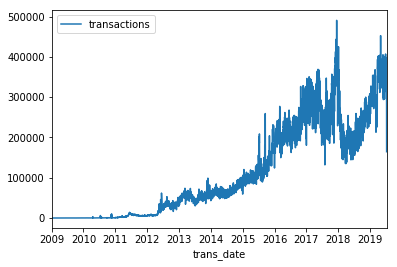

In [9]:
transactions_by_date.set_index('trans_date').plot()

As you can see, common table expressions (CTEs) let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.

# Exercises

You'll work with a dataset about taxi trips in the city of Chicago. Run the cell below to fetch the `chicago_taxi_trips` dataset.

In [10]:
client = bigquery.Client()

db_ref = client.dataset("chicago_taxi_trips", project = "bigquery-public-data")
db = client.get_dataset(db_ref)

You are curious how much slower traffic moves when traffic volume is high. This involves a few steps.

## Find the data
Before you can access the data, you need to find the table name with the data.

*Hint*: Tab completion is helpful whenever you can't remember a command. Type `client.` and then hit the tab key. Don't forget the period before hitting tab.

In [12]:
for t in client.list_tables(db):
    print(t.table_id)

taxi_trips


### Peek at the data

Use the next code cell to peek at the top few rows of the data. Inspect the data and see if any issues with data quality are immediately obvious.

In [13]:
tb_ref = db.table("taxi_trips")
tb = client.get_table(tb_ref)

client.list_rows(tb, max_results = 5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,8942f4c92b492ef57eec0777046211e300f47c99,9eb860ce5cb7ff8e35eaf83b4a6d5a5f97710448b10fd7...,2014-09-21 14:00:00+00:00,2014-09-21 14:15:00+00:00,600,2.6,None,None,None,None,...,0.0,9.05,Cash,None,None,None,None,None,None,None
1,6847a885605e1a98a7e97cb7a0922b5d5dc4d576,9eb860ce5cb7ff8e35eaf83b4a6d5a5f97710448b10fd7...,2014-09-21 14:45:00+00:00,2014-09-21 14:45:00+00:00,480,1.7,None,None,None,None,...,0.0,7.45,Cash,None,None,None,None,None,None,None
2,7357a709641e20156839ead21822f4e07d8e50f5,9eb860ce5cb7ff8e35eaf83b4a6d5a5f97710448b10fd7...,2014-09-21 14:45:00+00:00,2014-09-21 15:00:00+00:00,480,0.8,None,None,None,None,...,0.0,6.05,Cash,None,None,None,None,None,None,None
3,793b87591b2afd879eed1fd871547a25c7a917e5,9eb860ce5cb7ff8e35eaf83b4a6d5a5f97710448b10fd7...,2014-09-21 14:30:00+00:00,2014-09-21 14:30:00+00:00,660,2.2,None,None,None,None,...,0.0,8.65,Cash,None,None,None,None,None,None,None
4,8858a7c0141d5a9c298b450cd6fc4b91f1ee1ab2,9eb860ce5cb7ff8e35eaf83b4a6d5a5f97710448b10fd7...,2014-09-21 12:45:00+00:00,2014-09-21 13:00:00+00:00,360,1.1,None,None,None,None,...,1.0,7.05,Cash,None,None,None,None,None,None,None


### Determine when this data is from

If the data is sufficiently old, we might be careful before assuming the data is still relevant to traffic patterns today. Write a query that counts the number of trips in each year.  

Your results should have two columns:
- `year` - the year of the trips
- `num_trips` - the number of trips in that year

Hints:
- When using **GROUP BY** and **ORDER BY**, you should refer to the columns by the alias `year` that you set at the top of the **SELECT** query.
- The SQL code to **SELECT** the year from `trip_start_timestamp` is <code>SELECT **EXTRACT(YEAR FROM trip_start_timestamp)**</code>
- The **FROM** field can be a little tricky until you are used to it.  The format is:
    1. A backick (the symbol \`).
    2. The project name. In this case it is `bigquery-public-data`.
    3. A period.
    4. The dataset name. In this case, it is `chicago_taxi_trips`.
    5. A period.
    6. The table name. You used this as your answer in **1) Find the data**.
    7. A backtick (the symbol \`).

In [22]:
query = """
        SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, COUNT(1) AS num_trips
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        GROUP BY year
        ORDER BY year
        """
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

query_job = client.query(query, job_config = safe_config)

result = query_job.to_dataframe()

result

,year,num_trips
0,2013,27217716
1,2014,37395436
2,2015,32385875
3,2016,31759339
4,2017,24988003
5,2018,20732088
6,2019,5500519


### Dive slightly deeper

It's odd that 2017 (2019?) had so few rides. You should wonder whether it was systematic under-reporting throughout the year, or whether some months are missing.  Copy the query you used above in `rides_per_year_query` into the cell below for `rides_per_month_query`.  Then modify it in two ways:
1. Use a **WHERE** clause to limit the query to data from 2017.
2. Modify the query to extract the month rather than the year.

In [24]:
query = """
        SELECT EXTRACT(MONTH FROM trip_start_timestamp) AS month, COUNT(1) AS num_trips
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE EXTRACT(YEAR FROM trip_start_timestamp) = 2017
        GROUP BY month
        ORDER BY month
        """
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

query_job = client.query(query, job_config = safe_config)

result = query_job.to_dataframe()

result

,month,num_trips
0,1,1972071
1,2,1909802
2,3,2362105
3,4,2194702
4,5,2323386
5,6,2324472
6,7,2054299
7,8,2079861
8,9,1950631
9,10,2141197


### Write the query

It's time to step up the sophistication of your queries.  Write a query that shows, for each hour of the day in the dataset, the corresponding number of trips and average speed.

Your results should have three columns:
- `hour_of_day` - sort by this column, which holds the result of extracting the hour from `trip_start_timestamp`.
- `num_trips` - the count of the total number of trips in each hour of the day (e.g. how many trips were started between 6AM and 7AM, independent of which day it occurred on).
- `avg_mph` - the average speed, measured in miles per hour, for trips that started in that hour of the day.  Average speed in miles per hour is calculated as `3600 * SUM(trip_miles) / SUM(trip_seconds)`. (The value 3600 is used to convert from seconds to hours.)

For 2017, we're missing August and everything after. So restrict your query to data meeting the following criteria:
- a `trip_start_timestamp` between **2017-01-01** and **2017-07-01**
- `trip_seconds` > 0 and `trip_miles` > 0

You will use a common table expression (CTE) to select just the relevant rides.  Because this dataset is very big, this CTE should select only the columns you'll need to create the final output (though you won't actually create those in the CTE -- instead you'll create those in the later **SELECT** statement below the CTE).

This is a much harder query than anything you've written so far.  Good luck!

In [38]:
query = """
        WITH relevant AS
        (
        SELECT trip_start_timestamp, trip_miles, trip_seconds
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE trip_seconds > 0 AND 
        trip_miles > 0 AND 
        trip_start_timestamp > "2017-01-01" AND 
        trip_start_timestamp < "2017-07-01"
        )
        SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, 
        COUNT(1) AS num_trips, 
        3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
        
        FROM relevant
        GROUP BY hour_of_day
        ORDER BY hour_of_day        
        """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

query_job = client.query(query, job_config = safe_config)

result = query_job.to_dataframe()

result

,hour_of_day,num_trips,avg_mph
0,0,319339,20.230524
1,1,266529,18.937621
2,2,210147,18.777070
3,3,159668,20.158048
4,4,122183,26.736014
5,5,119312,30.769172
6,6,182738,24.588313
7,7,358406,17.735967
8,8,541775,15.079892
9,9,565548,16.543882
